# Задание 3

Проверить мощность и консервативность критериев Вальда и Фишера для линейной модели (в wald_test поставить флаг use_f=False)

# Импорт основных библиотек

In [2]:
import numpy as np
import scipy.stats as st
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols


# Генерация данных

Сначала напишем функцию для получения данных в модели линейной регрессии, пока что признак у каждого объекта будет $1$:
$y_i = \beta_0 + \beta_1 \cdot x_i + \varepsilon_i, i \in \overline{1, n}, \varepsilon_i \in \mathcal{N}(0, \sigma^2)$, $\beta_0$ и $\beta_1$ - параметры регрессии, $\varepsilon_i$ - независимые между собой случайные шумы, $\sigma$ - параметр шума.

In [3]:
def generate_y_1_feature(n, X, beta0, beta1, sigma):
    eps = np.random.randn(n)
    Y = beta0 + X*beta1 + sigma*eps
    return Y

Пока что будем генерировать данные в предположении, что зависимость $y(x)$ есть, то есть $\beta_1 \neq 0$.

In [4]:
n = 50
X = np.arange(n)
beta1 = 1
beta0 = 10
sigma = 1
Y = generate_y_1_feature(n, X, beta0, beta1, sigma)

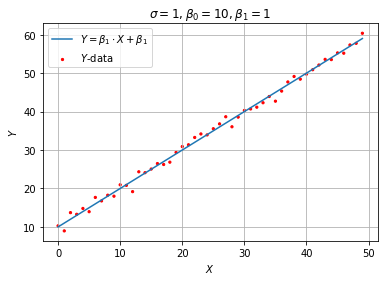

In [5]:
fig = plt.figure()

plt.xlabel(r'$X$') 
plt.ylabel(r'$Y$') 
plt.title(r'$\sigma = {0}, \beta_0 = {1}, \beta_1 = {2}$'.format(sigma, beta0, beta1)) 

line = X*beta1 + beta0

s = [5 for n in range(Y.shape[0])]
plt.scatter(X, Y, label = '$Y$-data', s = s, color = 'r')

plt.plot(X, line, label = r'$Y = \beta_1 \cdot X + \beta_1$')


plt.legend()
plt.grid(True) 
plt.show()

# Линейная регрессия

Построим линейную регрессию, для чего запишем данные в dataframe.

In [6]:
data_1 = pd.DataFrame({'X': X, 'Y': Y})

In [7]:
model_1 = sm.OLS.from_formula('Y~X', data_1)
results = model_1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     9912.
Date:                Sat, 27 Apr 2019   Prob (F-statistic):           2.83e-57
Time:                        18:24:10   Log-Likelihood:                -71.041
No. Observations:                  50   AIC:                             146.1
Df Residuals:                      48   BIC:                             149.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.0718      0.285     35.348      0.000       9.499      10.645
X              0.9976      0.010     99.557      0.000       0.977       1.018
==============================================================================
Omnibus:                        4.902   Durbin-Watson:                   2.276
Prob(Omnibus):                  0.086   Jarque-Bera (JB):                3.866
Skew:                          -0.647   Prob(JB):                        0.145
Kurtosis:                       3.428   Cond. No.                         56.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Проверим, что тесты Вальда и Фишера отклоняют нулевую гипотезу о том, что $\beta_1 = 0$.
Вспомним статистику для теста Фишера.
$$R^2 = \frac{ESS}{TSS} = \frac{\sum\limits_{i = 1}^n (\hat{y}_i - \overline{y})^2}{\sum\limits_{i = 1}^n (\hat{y}_i - y_i)^2},$$ где $\overline{y}$ - среднее значение данных $y_i, i \in \overline{1,n}$, $\hat{y}_i$ - предсказание $i$-го отклика методом наименьших квадратов в модели линейной регрессии:
$$
\hat{y}_i = \beta_0 + \sum\limits_{j = 1}^n \beta_jx_{ij}.
$$
Тогда критерий Фишера имеет следующие вид:

$H_0: \beta_1 = \dotso = \beta_k = 0$ - нулевая гипотеза. 

$H_1:$ $H_0$ неверна.

Статистика: $F = \frac{\frac{R^2}{k}}{\frac{\bigl(1 - R^2\bigr)}{n - k - 1}}$.

Нулевое распределение: $F(k, n - k - 1)$.

В критерии Вальда нулевое распределение заменяется на асимптотическое хи-квадрат распределение:

при $n \to \infty$ имеет место сходимость по распределению $kF(k, n - k - 1) \to \chi^2(k)$.

In [8]:
model_2 = ols('Y ~ X', data=data_1).fit()
model_2.wald_test('X=0', use_f=False)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[9911.6956331]], p-value=0.0, df_denom=1>

In [9]:
model_2.f_test('X=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[9911.6956331]]), p=2.831057916378167e-57, df_denom=48, df_num=1>

Для нашего шума оба теста на уровне значимости $\alpha = 0.05$ отклоняют нулевую гипотезу, что соответствует действительности: данные генерировались из условия $\beta_1 = 1$.

# Оценка мощности тестов Фишера и Вальда

Мощность критерия:
$W = \mathbb{P}\bigl\{{\text{отклонить }H_0 \; | \; \text{верна } H_1}\bigr\} = W(\beta_0, \beta_1, \sigma)$ - функция от параметров генерации данных, так как альтернатива сложная.
Для оценки мощности критериев проведем следующий эксперимент:

1) сгенерируем $m$ пар выборок, соответствующих альтернативной гипотезе $H_1$: $Z = \Bigl((X_1, Y_1), ..., (X_m, Y_m)\Bigr)$;

2) для каждой выборки проведем тесты Фишера и Вальда, а также найдем $p-value$. На уровне значимости $\alpha = 0.05$ определим, отвергается ли нулевая гипотеза. Доля отвергнутых гипотез и будет оценкой мощности. 

Интересно посмотреть на поведение тестов при достаточно маленьком значении $\beta_1$, однако, ненулевом, скажем, $\beta_1 = 0.001$. Для хорошей аппроксимации реальной мощности критериев будем брать $m$ достаточно большим, скажем, $m = 1000$.

Параметры эксперимента: $n = 50$ - число объектов в 1 выборке, $m = 1000$ - число выборок, $\sigma = 1$, $\beta_1 = 0.001, \beta_0 = 10$ - параметры генерации данных. Важно заметить, что в нашем эксперименте диапазон изменений признаков - $x_i$ - оставался постоянным, в интервале от $0$ до $n - 1$ с шагом $1$. 

In [85]:
def count_rejections(n, m, beta0, beta1, sigma, test, alpha = 0.05):
    rejected = 0
    X = np.arange(n)
    for i in range(m):
        Y = generate_y_1_feature(n, X, beta0, beta1, sigma)
        data = pd.DataFrame({'X': X, 'Y': Y})
        model = ols('Y ~ X', data=data).fit()
        if (test == 'wald'):
            print("Wald, p-value = {0}".format(float(model.wald_test('X=0', use_f=False).pvalue)))
            rejected += float(model.wald_test('X=0', use_f=False).pvalue) <= alpha
        elif test == 'fisher':
            print("Fisher, p-value = {0}".format(float(model.f_test('X=0').pvalue)))
            rejected += float(model.f_test('X=0').pvalue) <= alpha
    return rejected

In [87]:
m = 1000
n = 50
beta1 = 0.001
beta0 = 10
sigma = 1
W_wald = count_rejections(n, m, beta0, beta1, sigma, 'wald')/m
W_fisher = count_rejections(n, m, beta0, beta1, sigma, 'fisher')/m

Wald, p-value = 0.04113762222441034
Wald, p-value = 0.5802579224987342
Wald, p-value = 0.381275524711421
Wald, p-value = 0.6955398643873963
Wald, p-value = 0.2707983671059538
Wald, p-value = 0.976398216553508
Wald, p-value = 0.815735079008477
Wald, p-value = 0.34727483724649477
Wald, p-value = 0.4506242309934805
Wald, p-value = 0.36495490808979736
Wald, p-value = 0.8750536471150373
Wald, p-value = 0.07995933129009591
Wald, p-value = 0.8565778260349302
Wald, p-value = 0.5594279142106757
Wald, p-value = 0.515296194468573
Wald, p-value = 0.6618705512962578
Wald, p-value = 0.1270665212150019
Wald, p-value = 0.620243267879901
Wald, p-value = 0.2857314701983139
Wald, p-value = 0.3544915554332093
Wald, p-value = 0.1827208032822908
Wald, p-value = 0.07833191782531572
Wald, p-value = 0.46377653722361434
Wald, p-value = 0.21186590292431115
Wald, p-value = 0.4072192044660329
Wald, p-value = 0.9909979941332935
Wald, p-value = 0.28503263283933217
Wald, p-value = 0.28574656414255123
Wald, p-value = 

Wald, p-value = 0.031201579196896014
Wald, p-value = 0.9523354462586929
Wald, p-value = 0.9483610817096532
Wald, p-value = 0.6609752781891576
Wald, p-value = 0.3733829576228732
Wald, p-value = 0.39027994298424085
Wald, p-value = 0.13700537754842204
Wald, p-value = 0.2959682388159763
Wald, p-value = 0.24964811754042124
Wald, p-value = 0.6627803057081842
Wald, p-value = 0.5206698404597763
Wald, p-value = 0.42587023749514563
Wald, p-value = 0.32783620132483066
Wald, p-value = 0.21100631344829943
Wald, p-value = 0.6898400041922146
Wald, p-value = 0.4621215621329129
Wald, p-value = 0.60917141652914
Wald, p-value = 0.18488195400593876
Wald, p-value = 0.5853027527071575
Wald, p-value = 0.6743661246071133
Wald, p-value = 0.05563857210320458
Wald, p-value = 0.3072550343580286
Wald, p-value = 0.3687086117411519
Wald, p-value = 0.9343817638543629
Wald, p-value = 0.8945139191494392
Wald, p-value = 0.4688934140395502
Wald, p-value = 0.034960909658950864
Wald, p-value = 0.7530179512338968
Wald, p-va

Wald, p-value = 0.8892545464902759
Wald, p-value = 0.5254921906685681
Wald, p-value = 0.4336954248740015
Wald, p-value = 0.6932403390708455
Wald, p-value = 0.21017700257645142
Wald, p-value = 0.516515216264039
Wald, p-value = 0.5074433566481162
Wald, p-value = 0.3981116931219072
Wald, p-value = 0.2934134212545735
Wald, p-value = 0.2567262149021403
Wald, p-value = 0.12509036356710965
Wald, p-value = 0.8147408276338243
Wald, p-value = 0.9117382888246375
Wald, p-value = 0.9742664056139372
Wald, p-value = 0.21763050467671025
Wald, p-value = 0.025548247200282318
Wald, p-value = 0.9549466031899438
Wald, p-value = 0.3353455973952153
Wald, p-value = 0.12539317278773673
Wald, p-value = 0.3920039790789861
Wald, p-value = 0.38939664001247587
Wald, p-value = 0.09349035104255143
Wald, p-value = 0.6648345851755644
Wald, p-value = 0.27846999645367765
Wald, p-value = 0.7361046494040508
Wald, p-value = 0.5203988846400219
Wald, p-value = 0.1501336475559939
Wald, p-value = 0.8015950561020162
Wald, p-valu

Wald, p-value = 0.01674241410004463
Wald, p-value = 0.5901607689488906
Wald, p-value = 0.5298084697678112
Wald, p-value = 0.014434611974316785
Wald, p-value = 0.33829391347991544
Wald, p-value = 0.9545912599884748
Wald, p-value = 0.5061471475550023
Wald, p-value = 0.5220917194567931
Wald, p-value = 0.8207130350596948
Wald, p-value = 0.4549244861579289
Wald, p-value = 0.339585685905738
Wald, p-value = 0.1708524638277949
Wald, p-value = 0.9350695875572734
Wald, p-value = 0.5452667327874929
Wald, p-value = 0.2889157369918487
Wald, p-value = 0.9722088653497716
Wald, p-value = 0.2914230825570455
Wald, p-value = 0.23558540257234253
Wald, p-value = 0.4564546424353537
Wald, p-value = 0.21722183584086396
Wald, p-value = 0.2825045670560361
Wald, p-value = 0.34138022918408495
Wald, p-value = 0.24966210060530686
Wald, p-value = 0.8540091485142945
Wald, p-value = 0.32743970281038864
Wald, p-value = 0.9190056336565695
Wald, p-value = 0.42934932756109445
Wald, p-value = 0.9028277779679141
Wald, p-val

Wald, p-value = 0.5791985646174063
Wald, p-value = 0.2514321075392526
Wald, p-value = 0.010152722080245093
Wald, p-value = 0.9225291742577956
Wald, p-value = 0.11624695522463438
Wald, p-value = 0.7716215877123928
Wald, p-value = 0.36223488090339406
Wald, p-value = 0.6639641898295412
Wald, p-value = 0.19918709546610378
Wald, p-value = 0.4934346991648264
Wald, p-value = 0.06935673989522044
Wald, p-value = 0.17951213737280725
Wald, p-value = 0.578264843740713
Wald, p-value = 0.6793448167283314
Wald, p-value = 0.3107422305967776
Wald, p-value = 0.28630329185393466
Wald, p-value = 0.22630454045611526
Wald, p-value = 0.21568378954407869
Wald, p-value = 0.049608668079176466
Wald, p-value = 0.7877017279679721
Wald, p-value = 0.96679755578273
Wald, p-value = 0.604403936847957
Wald, p-value = 0.09853522953158436
Wald, p-value = 0.8266560849093029
Wald, p-value = 0.8353246199881792
Wald, p-value = 0.7922741554829957
Wald, p-value = 0.5628769411561965
Wald, p-value = 0.07001513656482546
Wald, p-va

Fisher, p-value = 0.4612124139249991
Fisher, p-value = 0.9902178120974973
Fisher, p-value = 0.5154310481724708
Fisher, p-value = 0.06274642222057544
Fisher, p-value = 0.4730380315970034
Fisher, p-value = 0.7807676957076528
Fisher, p-value = 0.6003200343042372
Fisher, p-value = 0.21418729971852962
Fisher, p-value = 0.12284644208669378
Fisher, p-value = 0.36867930644299907
Fisher, p-value = 0.7312607666849615
Fisher, p-value = 0.9538274272011948
Fisher, p-value = 0.558746656029818
Fisher, p-value = 0.5530892611679135
Fisher, p-value = 0.8022696344963375
Fisher, p-value = 0.9205780317292311
Fisher, p-value = 0.6076919686692404
Fisher, p-value = 0.04758230417217228
Fisher, p-value = 0.30426392310194406
Fisher, p-value = 0.045549668362718045
Fisher, p-value = 0.33910508841434295
Fisher, p-value = 0.6384819319112354
Fisher, p-value = 0.3410852919450841
Fisher, p-value = 0.6672464914644682
Fisher, p-value = 0.45427729280701346
Fisher, p-value = 0.2760581287490439
Fisher, p-value = 0.805031977

Fisher, p-value = 0.5317729464679934
Fisher, p-value = 0.042344902789271735
Fisher, p-value = 0.00884585100434056
Fisher, p-value = 0.07697952830365687
Fisher, p-value = 0.38174333242584646
Fisher, p-value = 0.730994301958994
Fisher, p-value = 0.9166961572164817
Fisher, p-value = 0.16574295486472515
Fisher, p-value = 0.44956557216477944
Fisher, p-value = 0.8866741198064162
Fisher, p-value = 0.1393789038652767
Fisher, p-value = 0.00655608853395674
Fisher, p-value = 0.685906592157044
Fisher, p-value = 0.18311052593472196
Fisher, p-value = 0.30661667770069134
Fisher, p-value = 0.7349810583608256
Fisher, p-value = 0.8688279635641016
Fisher, p-value = 0.6302743782249808
Fisher, p-value = 0.24194898261863698
Fisher, p-value = 0.9047862518257542
Fisher, p-value = 0.30928968746449154
Fisher, p-value = 0.9880777871814944
Fisher, p-value = 0.0850107769351241
Fisher, p-value = 0.39138665427098696
Fisher, p-value = 0.6308099298775713
Fisher, p-value = 0.3881486651411792
Fisher, p-value = 0.8227746

Fisher, p-value = 0.6420214612301647
Fisher, p-value = 0.0626826719645282
Fisher, p-value = 0.9358967078598383
Fisher, p-value = 0.8043457459964143
Fisher, p-value = 0.5702521694565785
Fisher, p-value = 0.4085624467553065
Fisher, p-value = 0.4868674243460349
Fisher, p-value = 0.6808724576700713
Fisher, p-value = 0.8561844499749987
Fisher, p-value = 0.20328910045624574
Fisher, p-value = 0.13345257770188476
Fisher, p-value = 0.697600134552563
Fisher, p-value = 0.02455670207197592
Fisher, p-value = 0.8959360132053258
Fisher, p-value = 0.4980663423309537
Fisher, p-value = 0.07488084152906634
Fisher, p-value = 0.5307867028587108
Fisher, p-value = 0.6165456139816964
Fisher, p-value = 0.7437151396051642
Fisher, p-value = 0.29003379127472456
Fisher, p-value = 0.8316257732753667
Fisher, p-value = 0.08058358550587101
Fisher, p-value = 0.1800118227434802
Fisher, p-value = 0.7021739246417971
Fisher, p-value = 0.055255537355253924
Fisher, p-value = 0.45454947389273803
Fisher, p-value = 0.6281948793

Fisher, p-value = 0.2823579649689298
Fisher, p-value = 0.5235584459259106
Fisher, p-value = 0.9564781484271001
Fisher, p-value = 0.9275902613044762
Fisher, p-value = 0.33664866143997063
Fisher, p-value = 0.13104276834893697
Fisher, p-value = 0.2998933037822593
Fisher, p-value = 0.8772516465687634
Fisher, p-value = 0.5130364805960159
Fisher, p-value = 0.07182962390295615
Fisher, p-value = 0.1833535180899313
Fisher, p-value = 0.10838973722385896
Fisher, p-value = 0.8144382434847433
Fisher, p-value = 0.5791561604986835
Fisher, p-value = 0.11908959132561404
Fisher, p-value = 0.06322850602722599
Fisher, p-value = 0.7882226071766256
Fisher, p-value = 0.36870788030723933
Fisher, p-value = 0.6350302160532936
Fisher, p-value = 0.9042207233924412
Fisher, p-value = 0.15517068111980642
Fisher, p-value = 0.16780960114849117
Fisher, p-value = 0.19033164682106454
Fisher, p-value = 0.752511163740309
Fisher, p-value = 0.31597223006259806
Fisher, p-value = 0.9025101160405995
Fisher, p-value = 0.78551533

In [88]:
print("Оценочная мощность теста Вальда: {0}".format(W_wald))
print("Оценочная мощность теста Фишера: {0}".format(W_fisher))

Оценочная мощность теста Вальда: 0.064
Оценочная мощность теста Фишера: 0.048


Полученные значения достаточно маленькие. Это можно объяснить тем, что шум $\sigma = 1$ достаточно большой для такого диапазона данных. Попробуем уменьшить его до значения $\sigma = 0.01$.

In [89]:
m = 1000
n = 50
beta1 = 0.001
beta0 = 10
sigma = 0.01
W_wald = count_rejections(n, m, beta0, beta1, sigma, 'wald')/m
W_fisher = count_rejections(n, m, beta0, beta1, sigma, 'fisher')/m

Wald, p-value = 1.7385354531281215e-27
Wald, p-value = 2.5463384980005768e-34
Wald, p-value = 1.3810288769555497e-24
Wald, p-value = 1.6168106711645627e-31
Wald, p-value = 8.292956666463753e-22
Wald, p-value = 2.171997623740989e-18
Wald, p-value = 1.2490586825262585e-15
Wald, p-value = 1.5405973640434275e-23
Wald, p-value = 9.732440296100856e-45
Wald, p-value = 5.666487296219473e-49
Wald, p-value = 7.540354759958122e-36
Wald, p-value = 8.474357907577476e-25
Wald, p-value = 4.534679567167404e-26
Wald, p-value = 8.306620630071749e-34
Wald, p-value = 4.024391351730735e-24
Wald, p-value = 1.4795505197348164e-24
Wald, p-value = 7.152907069473823e-32
Wald, p-value = 9.293222063603599e-35
Wald, p-value = 2.0415693717805175e-23
Wald, p-value = 7.042907432012939e-26
Wald, p-value = 1.6197361419533535e-32
Wald, p-value = 2.624816165488207e-19
Wald, p-value = 6.268128173888621e-33
Wald, p-value = 1.0547729239529991e-26
Wald, p-value = 1.0864174392537348e-18
Wald, p-value = 4.3443961083604785e-17


Wald, p-value = 4.655970233286367e-33
Wald, p-value = 2.1995402906676715e-30
Wald, p-value = 2.4740691275246967e-20
Wald, p-value = 8.305512332833876e-30
Wald, p-value = 2.1300941117781635e-34
Wald, p-value = 1.9646092394872387e-16
Wald, p-value = 4.491954213103643e-15
Wald, p-value = 3.942423209657802e-19
Wald, p-value = 2.211808723202907e-31
Wald, p-value = 3.1775825242355466e-38
Wald, p-value = 1.590579414426688e-20
Wald, p-value = 3.469680622321269e-33
Wald, p-value = 1.204567805383507e-26
Wald, p-value = 2.651130702125682e-23
Wald, p-value = 3.1557472430354645e-29
Wald, p-value = 6.719228813794309e-20
Wald, p-value = 7.626969491098687e-37
Wald, p-value = 3.9860311815238195e-31
Wald, p-value = 4.4028902016665434e-16
Wald, p-value = 1.224631581737709e-24
Wald, p-value = 1.536920194014797e-21
Wald, p-value = 6.675582935409113e-18
Wald, p-value = 2.341260278253584e-22
Wald, p-value = 4.3520439219164753e-13
Wald, p-value = 7.978953256540249e-35
Wald, p-value = 7.667464010377262e-21
Wal

Wald, p-value = 2.5086250613041154e-18
Wald, p-value = 1.3019408509890393e-31
Wald, p-value = 2.3301545807985937e-18
Wald, p-value = 2.353722955684535e-23
Wald, p-value = 1.1902449832649547e-24
Wald, p-value = 1.895938712913498e-20
Wald, p-value = 3.7411346315290632e-19
Wald, p-value = 1.6844784842148804e-32
Wald, p-value = 3.860563920469933e-20
Wald, p-value = 6.046493882925714e-32
Wald, p-value = 6.235926161904796e-24
Wald, p-value = 6.104522749575688e-53
Wald, p-value = 5.630048350930145e-17
Wald, p-value = 1.4372588855703905e-28
Wald, p-value = 2.352057461383132e-16
Wald, p-value = 1.5524742383685044e-31
Wald, p-value = 5.619297074695423e-31
Wald, p-value = 1.478674136189271e-28
Wald, p-value = 3.3703717844943265e-28
Wald, p-value = 2.429976948760729e-28
Wald, p-value = 1.651803939879499e-22
Wald, p-value = 1.1009930849969618e-30
Wald, p-value = 3.902244707421971e-15
Wald, p-value = 5.322437479675484e-20
Wald, p-value = 3.3135935797013097e-37
Wald, p-value = 4.990895403155519e-36
W

Wald, p-value = 5.629728545518632e-19
Wald, p-value = 8.226277606249597e-14
Wald, p-value = 4.2972352434393555e-28
Wald, p-value = 2.2188978082671732e-14
Wald, p-value = 6.1958902342443065e-27
Wald, p-value = 1.3424421317584637e-38
Wald, p-value = 1.3474643595509066e-15
Wald, p-value = 2.385954535404517e-24
Wald, p-value = 4.108885169573943e-29
Wald, p-value = 3.288605067566781e-33
Wald, p-value = 1.7286704548453534e-20
Wald, p-value = 3.2194723628213566e-27
Wald, p-value = 1.1427298850695832e-20
Wald, p-value = 7.081713007873349e-18
Wald, p-value = 1.2931597623741466e-22
Wald, p-value = 2.087342220670748e-21
Wald, p-value = 9.056107424552498e-20
Wald, p-value = 3.559743072742901e-43
Wald, p-value = 1.228748208211653e-22
Wald, p-value = 1.7992993340176772e-21
Wald, p-value = 9.819085496015164e-20
Wald, p-value = 1.2673234835967629e-43
Wald, p-value = 2.0657010882773467e-41
Wald, p-value = 5.964451765173427e-17
Wald, p-value = 1.6173965717837168e-22
Wald, p-value = 4.642981569511732e-19

Wald, p-value = 9.549486015963993e-29
Wald, p-value = 1.502543220921775e-23
Wald, p-value = 7.204311366094432e-33
Wald, p-value = 8.813302383297456e-21
Wald, p-value = 1.8828249589643424e-24
Wald, p-value = 1.9697615044620358e-26
Wald, p-value = 2.124968436838106e-18
Wald, p-value = 8.833909296228705e-26
Wald, p-value = 3.988995583441917e-33
Wald, p-value = 1.2168819292056067e-16
Wald, p-value = 1.1889650237734393e-26
Wald, p-value = 5.732081799789964e-26
Wald, p-value = 1.3100108075606425e-21
Wald, p-value = 6.53798532648869e-31
Wald, p-value = 2.3030041296755675e-27
Wald, p-value = 8.293558505893903e-37
Wald, p-value = 4.853639265215757e-21
Wald, p-value = 3.0312930400422877e-24
Wald, p-value = 4.363738568832831e-20
Wald, p-value = 6.72656699717711e-24
Wald, p-value = 9.302888370814422e-35
Wald, p-value = 5.109852858684277e-19
Wald, p-value = 9.483290047895128e-23
Wald, p-value = 1.8215378562364026e-19
Wald, p-value = 3.324294131375716e-29
Wald, p-value = 2.138858795748027e-19
Wald, 

Fisher, p-value = 3.5787388418184287e-14
Fisher, p-value = 2.9415365760887523e-12
Fisher, p-value = 2.385314121479352e-15
Fisher, p-value = 3.177417125413969e-11
Fisher, p-value = 3.0819462664077027e-12
Fisher, p-value = 1.2998842732219798e-16
Fisher, p-value = 1.354267607075707e-17
Fisher, p-value = 1.819668488546112e-10
Fisher, p-value = 3.7186593453824826e-17
Fisher, p-value = 1.3408121353718944e-16
Fisher, p-value = 7.56656234862026e-15
Fisher, p-value = 2.2325287690394597e-11
Fisher, p-value = 3.661227540666173e-14
Fisher, p-value = 9.51055383319474e-15
Fisher, p-value = 4.307314132653361e-10
Fisher, p-value = 6.484013464632128e-16
Fisher, p-value = 4.210400384407989e-12
Fisher, p-value = 5.487492882078385e-12
Fisher, p-value = 4.5258089836881986e-17
Fisher, p-value = 7.760866684856118e-12
Fisher, p-value = 2.0652322007146317e-15
Fisher, p-value = 1.4318299070148436e-14
Fisher, p-value = 3.3455796691896487e-11
Fisher, p-value = 1.5225336645026128e-13
Fisher, p-value = 5.1719829047

Fisher, p-value = 1.210678540277608e-14
Fisher, p-value = 8.152564490132715e-13
Fisher, p-value = 1.4115560734151535e-12
Fisher, p-value = 2.9224393687962006e-15
Fisher, p-value = 4.3819615257993505e-11
Fisher, p-value = 3.3807638361130206e-11
Fisher, p-value = 1.9088358524366513e-12
Fisher, p-value = 5.44906647293377e-16
Fisher, p-value = 5.570412667833469e-13
Fisher, p-value = 2.0405011128677257e-16
Fisher, p-value = 3.077743817844897e-14
Fisher, p-value = 3.922606452756775e-14
Fisher, p-value = 1.3262069223057516e-10
Fisher, p-value = 7.967521921354454e-10
Fisher, p-value = 5.050598460584488e-14
Fisher, p-value = 7.834970173818829e-14
Fisher, p-value = 8.612664863956202e-16
Fisher, p-value = 7.946285369783517e-12
Fisher, p-value = 1.0691122937747449e-10
Fisher, p-value = 1.0232064946346782e-12
Fisher, p-value = 1.0601452763717415e-13
Fisher, p-value = 4.198325968388311e-14
Fisher, p-value = 9.261353569097343e-15
Fisher, p-value = 3.112431990410005e-11
Fisher, p-value = 1.85623207593

Fisher, p-value = 1.7438989922484858e-11
Fisher, p-value = 6.458030809816109e-16
Fisher, p-value = 1.3480137406274334e-15
Fisher, p-value = 1.6789857921398793e-12
Fisher, p-value = 5.312026532610822e-14
Fisher, p-value = 2.7882755239239675e-13
Fisher, p-value = 1.766266394320375e-12
Fisher, p-value = 3.1915891888821046e-12
Fisher, p-value = 1.6162601617368733e-11
Fisher, p-value = 6.262179490944432e-18
Fisher, p-value = 8.027512496097123e-14
Fisher, p-value = 2.4647854467381363e-11
Fisher, p-value = 8.29491282990909e-13
Fisher, p-value = 2.4432469911270714e-15
Fisher, p-value = 4.438776610464788e-10
Fisher, p-value = 3.4132006302177916e-16
Fisher, p-value = 3.2295969589341643e-12
Fisher, p-value = 5.683240546576194e-15
Fisher, p-value = 1.1234093026747914e-14
Fisher, p-value = 5.860645063961504e-15
Fisher, p-value = 1.3298652692570837e-11
Fisher, p-value = 4.790109816938183e-11
Fisher, p-value = 4.938400214617921e-14
Fisher, p-value = 5.007753689263225e-14
Fisher, p-value = 4.893588716

Fisher, p-value = 4.576459280441379e-12
Fisher, p-value = 5.758153060532789e-12
Fisher, p-value = 3.997899698642323e-14
Fisher, p-value = 2.0748790452616808e-13
Fisher, p-value = 9.311473303283577e-14
Fisher, p-value = 2.31557741091282e-10
Fisher, p-value = 2.2211041901447806e-11
Fisher, p-value = 1.5497706665163461e-12
Fisher, p-value = 1.1359773850016906e-17
Fisher, p-value = 2.05599150975048e-11
Fisher, p-value = 7.098614251787342e-11
Fisher, p-value = 5.5953475436511464e-14
Fisher, p-value = 1.98811732358437e-11
Fisher, p-value = 6.606668014010551e-12
Fisher, p-value = 6.592045064906618e-14
Fisher, p-value = 9.780459230352488e-15
Fisher, p-value = 1.0290917428873597e-09
Fisher, p-value = 6.61675037396376e-14
Fisher, p-value = 2.737814149499149e-16
Fisher, p-value = 7.861482599655074e-13
Fisher, p-value = 3.655313622934096e-15
Fisher, p-value = 3.545280036676273e-14
Fisher, p-value = 4.660095881764636e-13
Fisher, p-value = 7.014424022761395e-14
Fisher, p-value = 3.8514839085753915e-

Fisher, p-value = 3.580700390258189e-12
Fisher, p-value = 7.775413246013164e-16
Fisher, p-value = 8.581116564172733e-14
Fisher, p-value = 2.1894555918793016e-15
Fisher, p-value = 1.4255714605443363e-14
Fisher, p-value = 8.247776131030284e-12
Fisher, p-value = 5.251138561307791e-15
Fisher, p-value = 3.3434095353923708e-12
Fisher, p-value = 2.805208184362126e-13
Fisher, p-value = 1.2455083190681148e-16
Fisher, p-value = 5.89559179280036e-15
Fisher, p-value = 4.568493300531654e-12
Fisher, p-value = 1.91203970039717e-14
Fisher, p-value = 1.099105028038453e-15
Fisher, p-value = 1.4462010669141125e-15
Fisher, p-value = 2.1920054321327987e-14
Fisher, p-value = 1.811449092990008e-15
Fisher, p-value = 7.659650723720934e-12
Fisher, p-value = 2.286040395105895e-12
Fisher, p-value = 1.9155610547452976e-13
Fisher, p-value = 1.2710799028998665e-13
Fisher, p-value = 9.525058659950821e-09
Fisher, p-value = 5.438576533503033e-12
Fisher, p-value = 3.3494063902732324e-12
Fisher, p-value = 6.4145035053273

In [90]:
print("Оценочная мощность теста Вальда: {0}".format(W_wald))
print("Оценочная мощность теста Фишера: {0}".format(W_fisher))

Оценочная мощность теста Вальда: 1.0
Оценочная мощность теста Фишера: 1.0


Налицо изменение! Попробуем исследовать зависимость оценочной мощности критериев от уровня шума $\sigma$. Для того, чтобы код работал не очень долго, уменьшим число экспериментов до $m = 100$. Диапазон изменений для $\sigma$ возьмём от $0.01$ до $0.2$. Конечно, ожидается, убывающая зависимость, ведь большой шум мешает определить коэффициент регрессии.

# Исследование оценочной мощности критериев от уровня шума

In [101]:
def count_rejections_without_print(n, m, beta0, beta1, sigma, test, alpha = 0.05):
    rejected = 0
    X = np.arange(n)
    for i in range(m):
        Y = generate_y_1_feature(n, X, beta0, beta1, sigma)
        data = pd.DataFrame({'X': X, 'Y': Y})
        model = ols('Y ~ X', data=data).fit()
        if (test == 'wald'):
            rejected += float(model.wald_test('X=0', use_f=False).pvalue) <= alpha
        elif test == 'fisher':
            rejected += float(model.f_test('X=0').pvalue) <= alpha
    return rejected

m = 100

sigma_arr = np.linspace(0.01, 0.2, num=10, endpoint=True)
W_wald_arr_sigma = []
W_fisher_arr_sigma = []
for i in range(10):
    W_wald_arr_sigma.append(count_rejections_without_print(n, m, beta0, beta1, sigma_arr[i], 'wald')/m)
    W_fisher_arr_sigma.append(count_rejections_without_print(n, m, beta0, beta1, sigma_arr[i], 'fisher')/m)
    print("sigma = {0}, оценочная мощность теста Вальда: {1}".format(sigma_arr[i], W_wald_arr_sigma[i]))
    print("sigma = {0}, оценочная мощность теста Фишера: {1}".format(sigma_arr[i], W_fisher_arr_sigma[i]))

sigma = 0.01, оценочная мощность теста Вальда: 1.0
sigma = 0.01, оценочная мощность теста Фишера: 1.0
sigma = 0.03111111111111111, оценочная мощность теста Вальда: 0.95
sigma = 0.03111111111111111, оценочная мощность теста Фишера: 0.95
sigma = 0.052222222222222225, оценочная мощность теста Вальда: 0.48
sigma = 0.052222222222222225, оценочная мощность теста Фишера: 0.48
sigma = 0.07333333333333333, оценочная мощность теста Вальда: 0.31
sigma = 0.07333333333333333, оценочная мощность теста Фишера: 0.27
sigma = 0.09444444444444444, оценочная мощность теста Вальда: 0.13
sigma = 0.09444444444444444, оценочная мощность теста Фишера: 0.14
sigma = 0.11555555555555555, оценочная мощность теста Вальда: 0.18
sigma = 0.11555555555555555, оценочная мощность теста Фишера: 0.13
sigma = 0.1366666666666667, оценочная мощность теста Вальда: 0.11
sigma = 0.1366666666666667, оценочная мощность теста Фишера: 0.1
sigma = 0.1577777777777778, оценочная мощность теста Вальда: 0.15
sigma = 0.1577777777777778, о

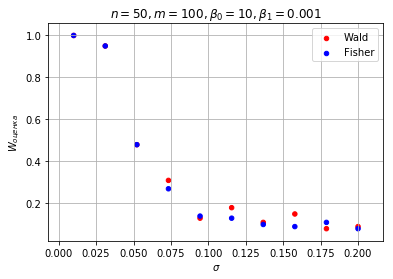

In [102]:
fig = plt.figure()

plt.xlabel(r'$\sigma$') 
plt.ylabel(r'$W_{оценка}$') 
plt.title(r'$n = {0}, m = {1}, \beta_0 = {2}, \beta_1 = {3}$'.format(n, m, beta0, beta1)) 


s = [20 for n in range(sigma_arr.shape[0])]
plt.scatter(sigma_arr,  W_wald_arr_sigma, label = 'Wald', s = s, color = 'r')
plt.scatter(sigma_arr,  W_fisher_arr_sigma, label = 'Fisher', s = s, color = 'b')

plt.legend()
plt.grid(True) 
plt.show()

Видно, что шум очень влияет на мощность критериев при маленьком значении параметра $\beta_1$. Посмотрим, как влияют параметры $\beta_0$ и $\beta_1$ на оценочную мощность критерия при фиксированном уровне шума $\sigma = 0.05$.  

# Исследование оценочной мощности критериев от параметров регрессии $\beta_0, \beta_1$

In [105]:
sigma = 0.05
beta1_arr = np.linspace(0.0001, 0.005, num=10, endpoint=True)
W_wald_arr_beta1 = []
W_fisher_arr_beta1 = []
for i in range(10):
    W_wald_arr_beta1.append(count_rejections_without_print(n, m, beta0, beta1_arr[i], sigma, 'wald')/m)
    W_fisher_arr_beta1.append(count_rejections_without_print(n, m, beta0, beta1_arr[i], sigma, 'fisher')/m)
    print("beta1 = {0}, оценочная мощность теста Вальда: {1}".format(beta1_arr[i], W_wald_arr_beta1 [i]))
    print("beta1 = {0}, оценочная мощность теста Фишера: {1}".format(beta1_arr[i], W_fisher_arr_beta1 [i]))

beta1 = 0.0001, оценочная мощность теста Вальда: 0.06
beta1 = 0.0001, оценочная мощность теста Фишера: 0.07
beta1 = 0.0006444444444444444, оценочная мощность теста Вальда: 0.32
beta1 = 0.0006444444444444444, оценочная мощность теста Фишера: 0.24
beta1 = 0.0011888888888888889, оценочная мощность теста Вальда: 0.7
beta1 = 0.0011888888888888889, оценочная мощность теста Фишера: 0.62
beta1 = 0.0017333333333333333, оценочная мощность теста Вальда: 0.88
beta1 = 0.0017333333333333333, оценочная мощность теста Фишера: 0.96
beta1 = 0.0022777777777777774, оценочная мощность теста Вальда: 1.0
beta1 = 0.0022777777777777774, оценочная мощность теста Фишера: 0.99
beta1 = 0.002822222222222222, оценочная мощность теста Вальда: 1.0
beta1 = 0.002822222222222222, оценочная мощность теста Фишера: 1.0
beta1 = 0.0033666666666666662, оценочная мощность теста Вальда: 1.0
beta1 = 0.0033666666666666662, оценочная мощность теста Фишера: 1.0
beta1 = 0.003911111111111111, оценочная мощность теста Вальда: 1.0
beta1

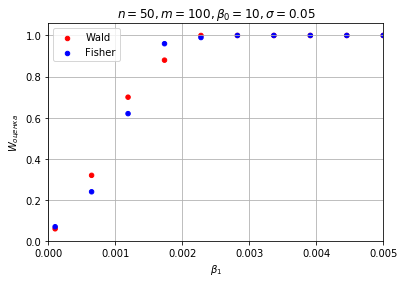

In [111]:
fig = plt.figure()

plt.xlabel(r'$\beta_1$') 
plt.ylabel(r'$W_{оценка}$') 
plt.title(r'$n = {0}, m = {1}, \beta_0 = {2}, \sigma = {3}$'.format(n, m, beta0, sigma)) 


s = [20 for n in range(beta1_arr.shape[0])]
plt.scatter(beta1_arr,  W_wald_arr_beta1, label = 'Wald', s = s, color = 'r')
plt.scatter(beta1_arr,  W_fisher_arr_beta1, label = 'Fisher', s = s, color = 'b')

plt.xlim((0,  max(beta1_arr)))
plt.legend()
plt.grid(True) 
plt.show()

In [114]:
beta1 = 0.001
beta0_arr = np.linspace(0, 10, num=10, endpoint=True)
W_wald_arr_beta0 = []
W_fisher_arr_beta0 = []
for i in range(10):
    W_wald_arr_beta0.append(count_rejections_without_print(n, m, beta0_arr[i], beta1, sigma, 'wald')/m)
    W_fisher_arr_beta0.append(count_rejections_without_print(n, m, beta0_arr[i], beta1, sigma, 'fisher')/m)
    print("beta0 = {0}, оценочная мощность теста Вальда: {1}".format(beta0_arr[i], W_wald_arr_beta0[i]))
    print("beta0 = {0}, оценочная мощность теста Фишера: {1}".format(beta0_arr[i], W_fisher_arr_beta0[i]))

beta0 = 0.0, оценочная мощность теста Вальда: 0.61
beta0 = 0.0, оценочная мощность теста Фишера: 0.56
beta0 = 1.1111111111111112, оценочная мощность теста Вальда: 0.54
beta0 = 1.1111111111111112, оценочная мощность теста Фишера: 0.48
beta0 = 2.2222222222222223, оценочная мощность теста Вальда: 0.53
beta0 = 2.2222222222222223, оценочная мощность теста Фишера: 0.58
beta0 = 3.3333333333333335, оценочная мощность теста Вальда: 0.64
beta0 = 3.3333333333333335, оценочная мощность теста Фишера: 0.5
beta0 = 4.444444444444445, оценочная мощность теста Вальда: 0.52
beta0 = 4.444444444444445, оценочная мощность теста Фишера: 0.46
beta0 = 5.555555555555555, оценочная мощность теста Вальда: 0.44
beta0 = 5.555555555555555, оценочная мощность теста Фишера: 0.52
beta0 = 6.666666666666667, оценочная мощность теста Вальда: 0.63
beta0 = 6.666666666666667, оценочная мощность теста Фишера: 0.59
beta0 = 7.777777777777779, оценочная мощность теста Вальда: 0.48
beta0 = 7.777777777777779, оценочная мощность те

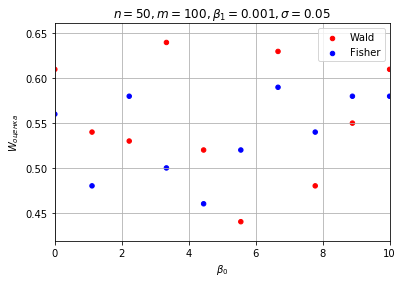

In [116]:
fig = plt.figure()

plt.xlabel(r'$\beta_0$') 
plt.ylabel(r'$W_{оценка}$') 
plt.title(r'$n = {0}, m = {1}, \beta_1 = {2}, \sigma = {3}$'.format(n, m, beta1, sigma)) 


s = [20 for n in range(beta1_arr.shape[0])]
plt.scatter(beta0_arr,  W_wald_arr_beta0, label = 'Wald', s = s, color = 'r')
plt.scatter(beta0_arr,  W_fisher_arr_beta0, label = 'Fisher', s = s, color = 'b')

plt.xlim((0,  max(beta0_arr)))
plt.legend()
plt.grid(True) 
plt.show()

Последняя зависимость, в отличие от предыдущей, больше напоминает шум.

# Консервативность тестов

Перейдём к исследованию консервативности тестов, то есть будем оценивать величину
$\mathbb{P}\bigl\{{\text{отклонить }H_0 \; | \; \text{верна } H_0}\bigr\} = P(\beta_0, \sigma)$ - ошибка первого рода.

In [125]:
beta1 = 0
beta0 = 10
m = 500

sigma_arr = np.linspace(0.01, 1, num=10, endpoint=True)
W_wald_arr_sigma_0 = []
W_fisher_arr_sigma_0 = []
for i in range(10):
    W_wald_arr_sigma_0.append(count_rejections_without_print(n, m, beta0, beta1, sigma_arr[i], 'wald')/m)
    W_fisher_arr_sigma_0.append(count_rejections_without_print(n, m, beta0, beta1, sigma_arr[i], 'fisher')/m)
    print("sigma = {0}, частота отклонения верной нулевой гипотезы, тест Вальда: {1}".format(sigma_arr[i], 
                                                                                             W_wald_arr_sigma_0[i]))
    print("sigma = {0}, частота отклонения верной нулевой гипотезы, тест Фишера: {1}".format(sigma_arr[i], 
                                                                                             W_fisher_arr_sigma_0[i]))

sigma = 0.01, частота отклонения верной нулевой гипотезы, тест Вальда: 0.056
sigma = 0.01, частота отклонения верной нулевой гипотезы, тест Фишера: 0.052
sigma = 0.12, частота отклонения верной нулевой гипотезы, тест Вальда: 0.06
sigma = 0.12, частота отклонения верной нулевой гипотезы, тест Фишера: 0.03
sigma = 0.23, частота отклонения верной нулевой гипотезы, тест Вальда: 0.06
sigma = 0.23, частота отклонения верной нулевой гипотезы, тест Фишера: 0.05
sigma = 0.34, частота отклонения верной нулевой гипотезы, тест Вальда: 0.07
sigma = 0.34, частота отклонения верной нулевой гипотезы, тест Фишера: 0.042
sigma = 0.45, частота отклонения верной нулевой гипотезы, тест Вальда: 0.058
sigma = 0.45, частота отклонения верной нулевой гипотезы, тест Фишера: 0.048
sigma = 0.56, частота отклонения верной нулевой гипотезы, тест Вальда: 0.042
sigma = 0.56, частота отклонения верной нулевой гипотезы, тест Фишера: 0.028
sigma = 0.67, частота отклонения верной нулевой гипотезы, тест Вальда: 0.056
sigm

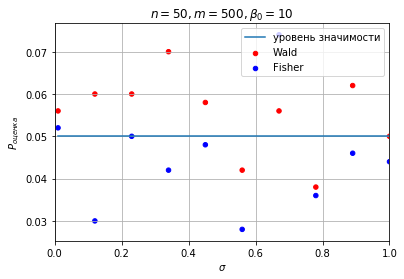

In [127]:
fig = plt.figure()

plt.xlabel(r'$\sigma$') 
plt.ylabel(r'$P_{оценка}$') 
plt.title(r'$n = {0}, m = {1}, \beta_0 = {2}$'.format(n, m, beta0, sigma)) 

alpha = 0.05
s = [20 for n in range(beta1_arr.shape[0])]
plt.plot(sigma_arr, [alpha for i in range(10)], label = 'уровень значимости')
plt.scatter(sigma_arr,  W_wald_arr_sigma_0, label = 'Wald', s = s, color = 'r')
plt.scatter(sigma_arr,  W_fisher_arr_sigma_0, label = 'Fisher', s = s, color = 'b')

plt.xlim((0,  max(sigma_arr)))
plt.legend()
plt.grid(True) 
plt.show()

Видно, что на разных уровнях шума в основном частота неправильных отклонений нулевой гипотезы наблюдается у теста Фишера по сравнению с приближённым тестом Вальда. Все, кроме $1$ точки, для теста Фишера лежат ниже уровня значимости, его можно считать консервативным в этом эксперименте. Посмотрим, как ведёт себя критерий при увеличении числа выборки $n$.

In [141]:
beta1 = 0
beta0 = 10
m = 500
sigma = 1
n_arr = [10*(i + 1) for i in range(20)]
W_wald_arr_n_0 = []
W_fisher_arr_n_0 = []
for i in range(20):
    W_wald_arr_n_0.append(count_rejections_without_print(n_arr[i], m, beta0, beta1, sigma, 'wald')/m)
    W_fisher_arr_n_0.append(count_rejections_without_print(n_arr[i], m, beta0, beta1, sigma, 'fisher')/m)
    print("n = {0}, частота отклонения верной нулевой гипотезы, тест Вальда: {1}".format(n_arr[i], 
                                                                                             W_wald_arr_n_0[i]))
    print("n = {0}, частота отклонения верной нулевой гипотезы, тест Фишера: {1}".format(n_arr[i], 
                                                                                             W_fisher_arr_n_0[i]))

n = 10, частота отклонения верной нулевой гипотезы, тест Вальда: 0.086
n = 10, частота отклонения верной нулевой гипотезы, тест Фишера: 0.036
n = 20, частота отклонения верной нулевой гипотезы, тест Вальда: 0.046
n = 20, частота отклонения верной нулевой гипотезы, тест Фишера: 0.048
n = 30, частота отклонения верной нулевой гипотезы, тест Вальда: 0.048
n = 30, частота отклонения верной нулевой гипотезы, тест Фишера: 0.052
n = 40, частота отклонения верной нулевой гипотезы, тест Вальда: 0.072
n = 40, частота отклонения верной нулевой гипотезы, тест Фишера: 0.058
n = 50, частота отклонения верной нулевой гипотезы, тест Вальда: 0.07
n = 50, частота отклонения верной нулевой гипотезы, тест Фишера: 0.05
n = 60, частота отклонения верной нулевой гипотезы, тест Вальда: 0.048
n = 60, частота отклонения верной нулевой гипотезы, тест Фишера: 0.046
n = 70, частота отклонения верной нулевой гипотезы, тест Вальда: 0.05
n = 70, частота отклонения верной нулевой гипотезы, тест Фишера: 0.034
n = 80, ч

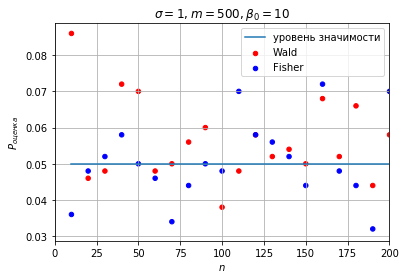

In [143]:
fig = plt.figure()

plt.xlabel(r'$n$') 
plt.ylabel(r'$P_{оценка}$') 
plt.title(r'$\sigma = {0}, m = {1}, \beta_0 = {2}$'.format(sigma, m, beta0)) 

alpha = 0.05
s = [20 for n in range(len(n_arr))]
plt.plot(n_arr, [alpha for i in range(20)], label = 'уровень значимости')
plt.scatter(n_arr,  W_wald_arr_n_0, label = 'Wald', s = s, color = 'r')
plt.scatter(n_arr,  W_fisher_arr_n_0, label = 'Fisher', s = s, color = 'b')

plt.xlim((0,  max(n_arr)))
plt.legend()
plt.grid(True) 
plt.show()

Здесь ситуация не такая однозначная. Наконец, будем менять уровень значимости $\alpha$.

In [139]:
beta1 = 0
beta0 = 10
m = 500
sigma = 1
n = 50
alpha_arr = [0.01*(i + 1) for i in range(10)]
W_wald_arr_alpha_0 = []
W_fisher_arr_alpha_0 = []
for i in range(10):
    W_wald_arr_alpha_0.append(count_rejections_without_print(n, m, beta0, beta1, sigma, 'wald', alpha_arr[i])/m)
    W_fisher_arr_alpha_0.append(count_rejections_without_print(n, m, beta0, beta1, sigma, 'fisher', alpha_arr[i])/m)
    print("alpha = {0}, частота отклонения верной нулевой гипотезы, тест Вальда: {1}".format(alpha_arr[i], 
                                                                                             W_wald_arr_alpha_0[i]))
    print("alpha = {0}, частота отклонения верной нулевой гипотезы, тест Фишера: {1}".format(alpha_arr[i], 
                                                                                             W_fisher_arr_alpha_0[i]))

alpha = 0.01, частота отклонения верной нулевой гипотезы, тест Вальда: 0.008
alpha = 0.01, частота отклонения верной нулевой гипотезы, тест Фишера: 0.01
alpha = 0.02, частота отклонения верной нулевой гипотезы, тест Вальда: 0.03
alpha = 0.02, частота отклонения верной нулевой гипотезы, тест Фишера: 0.016
alpha = 0.03, частота отклонения верной нулевой гипотезы, тест Вальда: 0.034
alpha = 0.03, частота отклонения верной нулевой гипотезы, тест Фишера: 0.032
alpha = 0.04, частота отклонения верной нулевой гипотезы, тест Вальда: 0.052
alpha = 0.04, частота отклонения верной нулевой гипотезы, тест Фишера: 0.032
alpha = 0.05, частота отклонения верной нулевой гипотезы, тест Вальда: 0.046
alpha = 0.05, частота отклонения верной нулевой гипотезы, тест Фишера: 0.042
alpha = 0.06, частота отклонения верной нулевой гипотезы, тест Вальда: 0.058
alpha = 0.06, частота отклонения верной нулевой гипотезы, тест Фишера: 0.046
alpha = 0.07, частота отклонения верной нулевой гипотезы, тест Вальда: 0.082
a

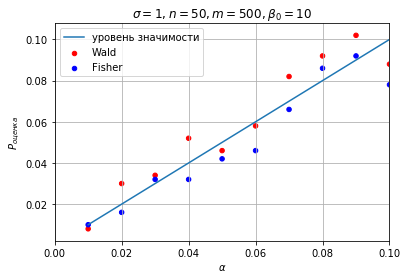

In [140]:
fig = plt.figure()

plt.xlabel(r'$\alpha$') 
plt.ylabel(r'$P_{оценка}$') 
plt.title(r'$\sigma = {0}, n = {1}, m = {2}, \beta_0 = {3}$'.format(sigma, n, m, beta0)) 

s = [20 for n in range(len(alpha_arr))]
plt.plot(alpha_arr, alpha_arr, label = 'уровень значимости')
plt.scatter(alpha_arr,  W_wald_arr_alpha_0, label = 'Wald', s = s, color = 'r')
plt.scatter(alpha_arr,  W_fisher_arr_alpha_0, label = 'Fisher', s = s, color = 'b')

plt.xlim((0,  max(alpha_arr)))
plt.legend()
plt.grid(True) 
plt.show()

На графике также изображена прямая $y = x$, точки ниже её соответствуют случаям, когда тест ошибается не чаще, чем в $100 \cdot \alpha\%$ случаев.
Видно, что для этого графика практически всегда тест Фишера оказывается консервативней теста Вальда. 

# Выводы

1) Мощность тестов очень сильно зависит от соотношения между шумом $\sigma$ и коэффициентом при признаке $\beta_1$. При фиксированных параметрах с увеличением шума мощность критериев падает, а с увеличением коэффициента $\beta_1$ - увеличивается. 

2) Экспериментальная ошибка первого рода для обоих тестов - Вальда и Фишера - достаточно близка к теоретической, можно считать тесты консервативными.